In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr

import sys
import os.path as op
ROOT = op.abspath(op.join(op.pardir,op.pardir))
DATA_PATH = op.join(ROOT, 'data') + '/'
sys.path.insert(0, op.join(ROOT, 'src'))
import stationary_wave.tools as tl

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In this notebook, we test the sigma-level stationary wave model on a case for which we have an analytical solution: the Gill problem, that describes the linear response of a dry atmosphere to an equatorial heat source.

In ideal_gill.pdf, we describe how the equations of motion in a continuous atmosphere can be reduced to the shallow-water equations for particular vertical structures. 

We begin by building an idealized basic state, and the accompanying heat source that only excites the first baroclinic mode. The, we analyze a shallow-water solution solved with Dedalus (see `shallow_water_ideal_gill.py`) and compare it with the analytical beta-plane solution from Gill (1980) (we follow the notation of Vallis' book). Finally, we analyze the sigma-level solution (ran using the script ```run_ideal_gill.py```) and compare it with the shallow-water solution.

# Making a basic state

In [3]:
# Open the NCEP-NCAR reanalysis January basic state (for comparison)
basic_state_ncep = xr.open_dataset(DATA_PATH + 'input/ncep_jan_basic_state.nc')

In [4]:
# Create idealized basic state dataset, initialized with zeros
nlat = 181
npres = 51
vars = ['U', 'V', 'W', 'T']
basic_state_skeleton = xr.Dataset({var: (['pressure', 'lat'], np.zeros((npres, nlat))) for var in vars}, 
                                  coords = {'pressure': np.linspace(0, 1e3, npres), 
                                            'lat': np.linspace(-90, 90, nlat)})

# Basic state surface pressure profile
ps = 1e3  # surface pressure in hPa
basic_state_skeleton['SP'] = (['lat',], 1e2 * ps * np.ones((nlat)))

# Basic state Temperature profile (see ideal_gill.pdf)
p = basic_state_skeleton.pressure
Ts = 300; 
gamma = 5e-5
kappa = 287/1004
const = 1 + gamma * ps ** 2 / (Ts * (2-kappa))
basic_state_skeleton['T'] = const * Ts * (p / ps) ** kappa - gamma * p ** 2 / (2-kappa) * basic_state_skeleton.lat ** 0
basic_state_skeleton['T'][:] = np.maximum(basic_state_skeleton['T'][:], 150)  # to avoid instabilities associated with vanishing static stability

Text(0, 0.5, 'Pressure (hPa)')

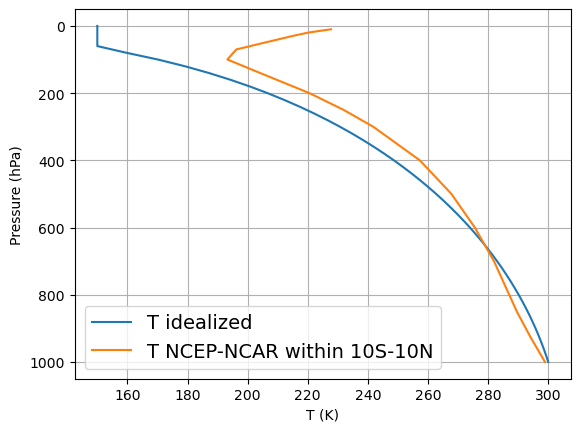

In [5]:
basic_state_skeleton['T'].sel(lat = slice(-10,10)).mean('lat').plot(y = 'pressure', yincrease=False, label='T idealized')
basic_state_ncep.T.sel(lat = slice(10,-10)).mean('lat').plot(y = 'pressure', yincrease=False, label='T NCEP-NCAR within 10S-10N')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('T (K)')
plt.ylabel('Pressure (hPa)')

In [6]:
# Create forcing dataset. Need to specify QDIAB, EHFD, EMFD_U, EMFD_V, ZSFC, SP; here, only QDIAB (and of course SP) is nonzero
# ZSFC is an idealized Tibetan plateau

vars = ['QDIAB', 'EHFD', 'EMFD_U', 'EMFD_V']
forcing_skeleton = xr.Dataset({var: (['pressure', 'lat', 'lon'], np.zeros((npres, nlat, 2*nlat-1))) for var in vars}, coords = {'pressure': np.linspace(0, 1e3, npres), 'lat': np.linspace(-90, 90, nlat), 'lon': np.linspace(-180, 180, 2*nlat-1)})
vars_sfc = ['ZSFC', 'SP']
for var in vars_sfc:
    forcing_skeleton[var] = (['lat','lon'], np.zeros((nlat, 2*nlat-1)))
forcing_skeleton['SP'][:] = ps * 1e2

# calculate the eigenvalue Kn (see ideal_gill.pdf), then equatorial Rossby radius
Kn = np.pi**2 / (287. * gamma * ps ** 2)
cn = np.sqrt(1/Kn)
R_earth = 6.37122e6  # Earth radius in meters
beta = 2 * 2 * np.pi / 86400 / R_earth
Leq = np.sqrt(cn / (2*beta))

# Calculate diabatic heating structure
Q_vert_structure = p * np.sin(np.pi * p / ps)
lon = forcing_skeleton.lon; lat = forcing_skeleton.lat
dlon = 20
lon_structure = np.cos(np.pi * (lon-90)/2/dlon) * (np.abs((lon-90)/dlon) < 1)
lat_structure = np.exp( - (R_earth * lat * np.pi / 180 / Leq)**2 / 4)
forcing_skeleton['QDIAB'] = 1 / 86400 * Q_vert_structure * lat_structure * lon_structure #1e-2 / 86400 *

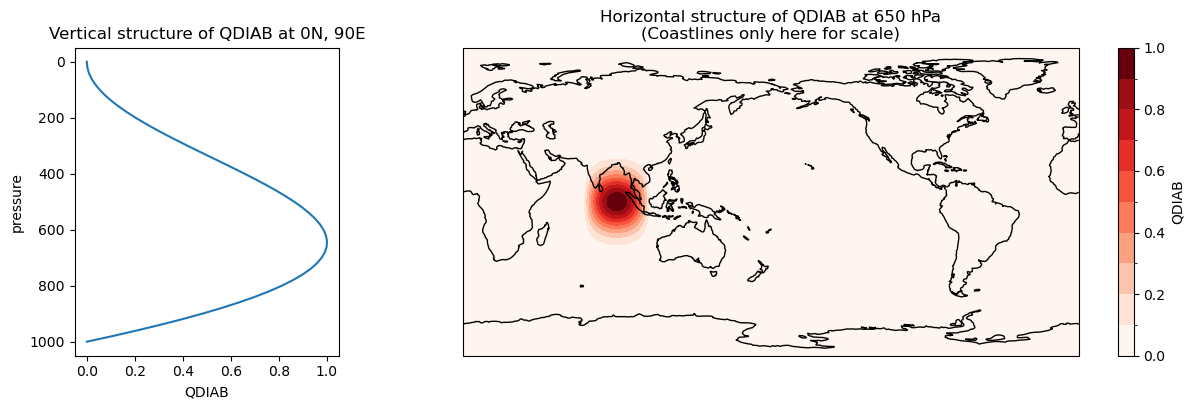

In [7]:
# Show forcing structure
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=(1, 3))

# Vertical structure
ax1 = fig.add_subplot(gs[0])
(forcing_skeleton.QDIAB / forcing_skeleton.QDIAB.max()).sel(lat=0,lon=90,method='nearest').plot(ax=ax1, y='pressure',yincrease=False)
ax1.set_title('Vertical structure of QDIAB at 0N, 90E')

# Horizontal structure
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
(forcing_skeleton.QDIAB / forcing_skeleton.QDIAB.max()).sel(pressure=650,method='nearest').plot.contourf(ax=ax2, cmap='Reds', levels=np.linspace(0., 1., 11), transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Horizontal structure of QDIAB at 650 hPa\n(Coastlines only here for scale)');

In [84]:
basic_state_skeleton.to_netcdf(DATA_PATH + 'input/ideal_Gill_basic_state.nc')
forcing_skeleton.to_netcdf(DATA_PATH + 'input/ideal_Gill_forcings.nc')

In [ ]:
# # Transform into Ting-model-compatible version
# forcing_Gill = xr.open_dataset('ideal_Gill_forcings.nc')
# forcing_Gill = lon_180_to_360(forcing_Gill['QDIAB'].rename(pressure='pre'))
# forcing_Gill = wrap_lon(forcing_Gill).isel(lon=slice(1,None))
# forcing_Gill.to_netcdf('ideal_Gill_QDIAB_forBill.nc')

# def adapt_basic_state(basic_state):
#     """
#     Transform the basic state to be compatible with Bill.
#     """
#     basic_state = basic_state.rename(pressure='pre')
#     basic_state = basic_state.expand_dims({'lon':145}).assign_coords(lon=np.linspace(0,360,145)).transpose('pre','lat','lon')
#     basic_state = basic_state.rename(U='u', V='v', W='w', T='t', SP='ps')
#     basic_state['ps'] = basic_state.ps.expand_dims({'time':1})
#     return basic_state

# basic_state_Gill = xr.open_dataset('ideal_Gill_basic_state.nc')
# basic_state_Gill['T'][:] = np.maximum(basic_state_Gill['T'].data,150)
# basic_state_Gill = adapt_basic_state(basic_state_Gill)
# basic_state_Gill.to_netcdf("ideal_Gill_basic_state_forBill.nc")

# Shallow water problem

In [ ]:
snapshot_id = 'stationarywave_SW_T32_ideal_Gill_linear'
gill_SW_T32 = tl.open_h5s(snapshot_id,('s1',))
gill_SW_T32_mean = gill_SW_T32.sel(t=slice(400,None)).mean('t').transpose('','latitude','longitude')

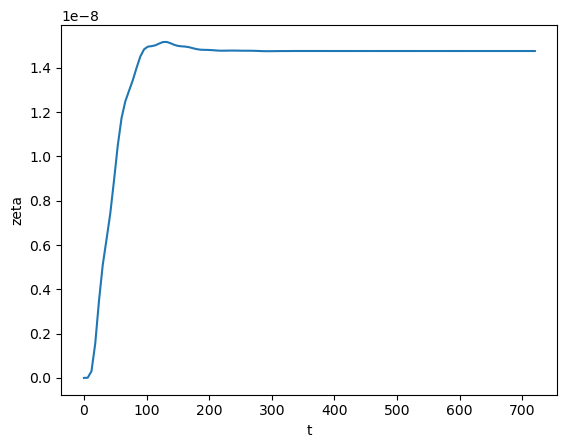

In [9]:
# Evolution of the mean enstrophy
(gill_SW_T32.zeta**2).mean(('latitude','longitude')).plot()

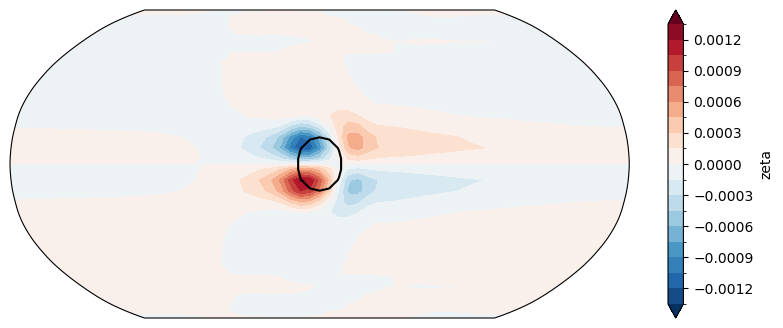

In [10]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
gill_SW_T32_mean.zeta.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
gill_SW_T32_mean.Q.plot.contour(ax=ax,levels=[5e-2],colors=['k'],transform=ccrs.PlateCarree())


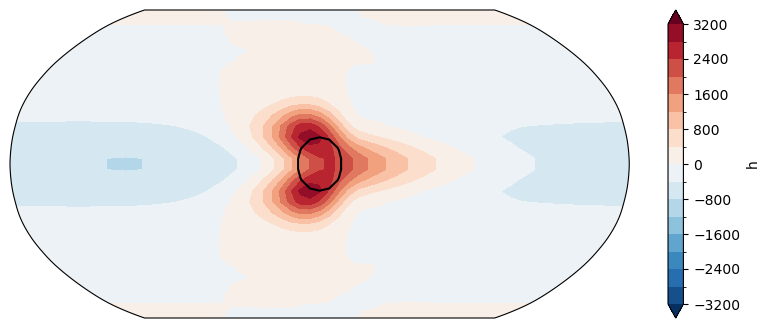

In [11]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
gill_SW_T32_mean.h.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
gill_SW_T32_mean.Q.plot.contour(ax=ax,levels=[5e-2],colors=['k'],transform=ccrs.PlateCarree())


Text(0.5, 1.0, 'divergence, wind, and heating (black contour)')

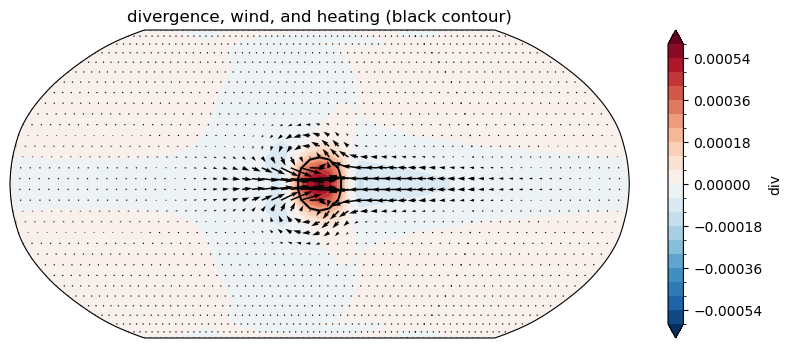

In [12]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
gill_SW_T32_mean.div.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
gill_SW_T32_mean.Q.plot.contour(ax=ax,levels=[5e-2],colors=['k'],transform=ccrs.PlateCarree())

u= (gill_SW_T32_mean.u[0])
v=-(gill_SW_T32_mean.u[1])
n=1; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], -np.array(u)[::n,::m], -np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=2e4)

plt.title('divergence, wind, and heating (black contour)')

## Dedalus shallow water solution vs beta-plane analytical solution

In [13]:
# Analytical solution from Vallis chapter 8 (p325)
Omega = 2*np.pi / 86400
a = 6.37122e6

ps = 1e3
gamma = 5e-5
Kn = np.pi**2 / (287. * gamma * ps ** 2)
cn = np.sqrt(1/Kn)
beta = 2 * Omega / a
Leq = np.sqrt(cn / (2*beta))
Teq = 1/np.sqrt(2 * cn * beta)

alpha = 0.5/ 86400 * Teq # nondim damping

L = a * 20 * np.pi / 180. / Leq # nondim length scale of forcing
A_dim = 1 / 86400 / (Kn * gamma * (ps/np.pi))  # Amplitude of forcing in m^2/s^3
A = Leq * A_dim / cn ** 3 # nondim amplitude of forcing
k = np.pi / (2*L) 

lons = np.linspace(-90,269,360)
lats = np.linspace(-90,90,181)
longitude = xr.DataArray(lons, dims='longitude', coords={'longitude': lons})
latitude = xr.DataArray(lats, dims='latitude', coords={'latitude': lats})
x = (longitude - 90)* np.pi / 180. * a / Leq
y_dim = latitude * np.pi / 180. * a

q0_inner = - A / (alpha**2 + k**2) * (alpha * np.cos(k*x) + k * (np.sin(k*x) + np.exp(-alpha * (x+L))))
q0_outer = - A * k / (alpha**2 + k**2) * (1 + np.exp(-2*alpha*L)) * np.exp(alpha * (L-x))
q0 = (np.abs(x) <= L) * q0_inner + (x > L) * q0_outer

q2_inner = A / ((3*alpha)**2 + k**2) * (- 3 * alpha * np.cos(k*x) + k * (np.sin(k*x) - np.exp(3 * alpha * (x-L))))
q2_outer = - A * k / ((3*alpha)**2 + k**2) * (1 + np.exp(-6*alpha*L)) * np.exp(3 * alpha * (L+x))
q2 = (np.abs(x) <= L) * q2_inner + (x < -L) * q2_outer


phi_tot = - cn**2/2 * (q0 + q2 * (1 + 2 * beta * y_dim**2/cn)) * np.exp(-beta * y_dim**2/2/cn)
phi_tot = phi_tot.transpose('latitude','longitude')
phi_tot = tl.prime(phi_tot)
# bring longitude back to -180,180 for comparison with Dedalus output
phi_tot = tl.lon_360_to_180(tl.lon_180_to_360(phi_tot))

Text(0.5, 1.0, 'Difference Dedalus - analytical')

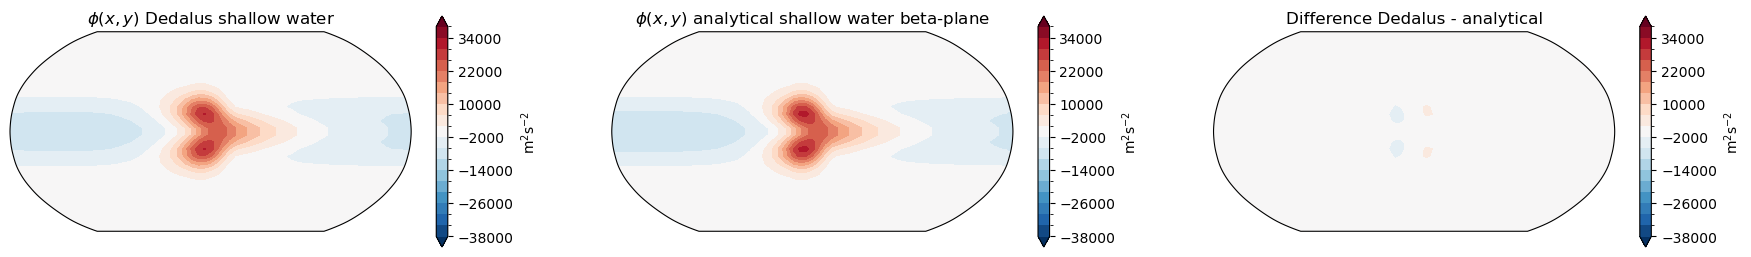

In [14]:
# Perturbation phi in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})

Phi_SW = gill_SW_T32_mean.h * 9.81
phi_tot_itp = tl.wrap_lon(tl.wrap_lon(phi_tot)).interp_like(Phi_SW)


levs = np.linspace(-1.9,1.9,20) * 2e4

Phi_SW.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
phi_tot_itp.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(Phi_SW - phi_tot_itp).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    pass
    # ax.coastlines()
    # ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$\phi(x,y)$ Dedalus shallow water')
axs[1].set_title(r'$\phi(x,y)$ analytical shallow water beta-plane')
axs[2].set_title('Difference Dedalus - analytical')
# axs[1,1].remove()

# Full n-level model

In [ ]:
ideal_T32 = tl.process_sigma_sim('stationarywave_20level_T32_ideal_Gill_linear',('s1',))

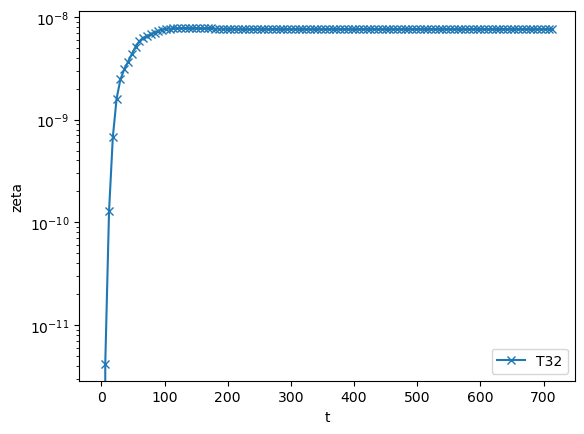

In [16]:
# CONVERGENCE
(ideal_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32',marker='x' )
# (ideal_T32_24levs.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32',marker='x' )

plt.legend()
plt.yscale('log')


Below, we show the vertical structure of the solution. The "expected vertical structures" are sine waves by construction; because we modified the ideal temperature profile to have an isothermal stratosphere (for stability reasons), the solutions deviate in the upper troposphere.

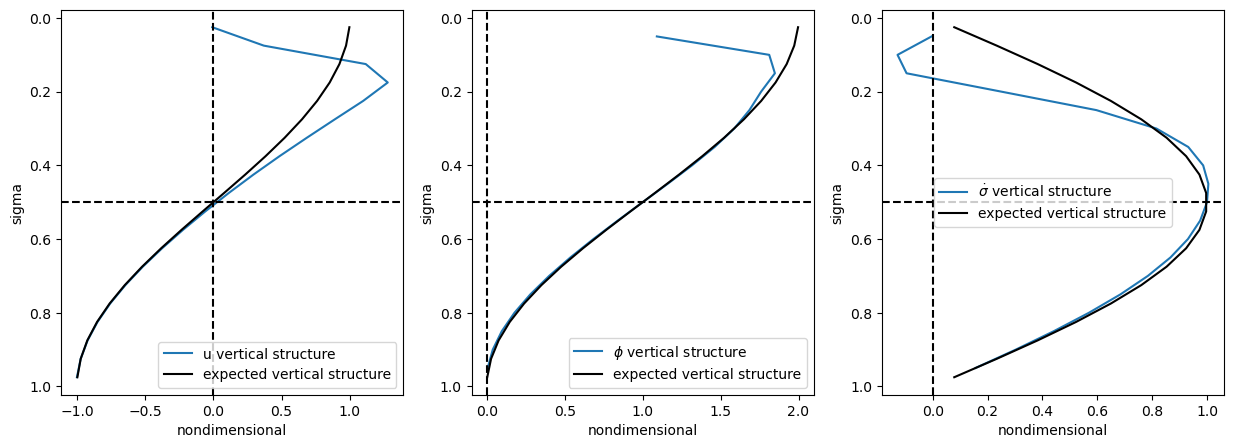

In [18]:
# Vertical structure of the solution
_,axs = plt.subplots(1,3,figsize=(15,5))

ax = axs[0]
(ideal_T32.u_mean[0]/(-ideal_T32.u_mean[0].isel(sigma=-1))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma',yincrease=False,label = 'u vertical structure')
np.cos(ideal_T32.sigma * np.pi).plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

ax = axs[1]
Phiprime_test = ideal_T32.Phiprime_mean.sel(latitude = 0,longitude=110,method='nearest')
(Phiprime_test / Phiprime_test.sel(sigma_stag=0.5,method='nearest') ).plot(ax=ax,y='sigma_stag',yincrease=False,label = r'$\phi$ vertical structure')
(1+np.cos(ideal_T32.sigma * np.pi)).plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

ax = axs[2]
(ideal_T32.sigmadot_mean/(ideal_T32.sigmadot_mean.sel(sigma_stag=0.5,method='nearest'))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma_stag',yincrease=False,label = r'$\dot \sigma$ vertical structure')
np.sin(ideal_T32.sigma * np.pi).plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

for ax in axs.flatten():
    ax.axvline(0., color='k', linestyle='--')
    ax.axhline(0.5, color='k', linestyle='--')
    ax.legend()
    ax.set_xlabel('nondimensional')

Below, we compare the horizontal structure of the solution with the shallow water solution. Given the vertical structures, we expect the surface wind field to be opposite of the shallow water solution, and the mid-tropospheric geopotential field to be equal to that of the shallow water solution.

Text(0.5, 1.0, 'Difference 14lev - SW')

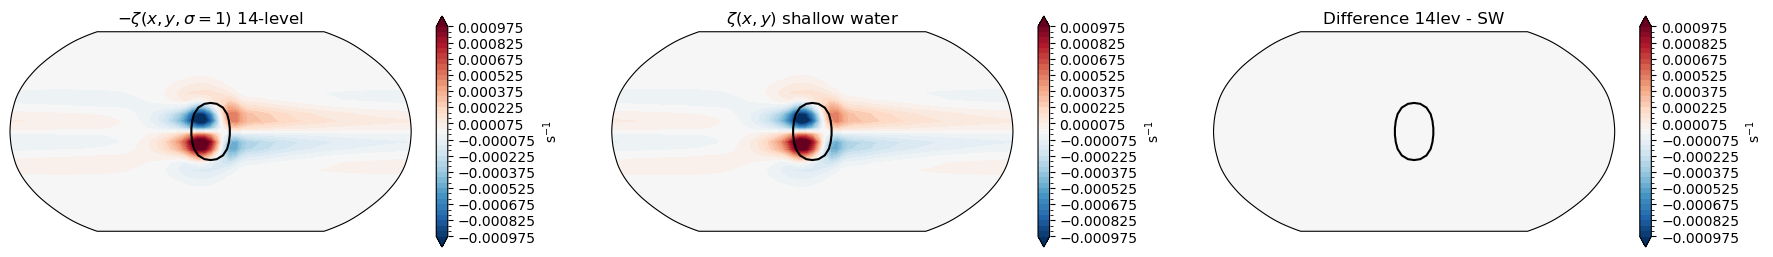

In [96]:
# Perturbation zeta in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
zeta_Nlev = (-ideal_T32.zeta_mean).sel(sigma=1,method='nearest')
zeta_SW = gill_SW_T32_mean.zeta
levs = np.linspace(-1.95,1.95,40) * 5e-4
zeta_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
zeta_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
(zeta_Nlev - zeta_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[1e-3],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$-\zeta(x,y,\sigma=1)$ 14-level')
axs[1].set_title(r'$\zeta(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()

Text(0.5, 1.0, 'Difference 14lev - SW')

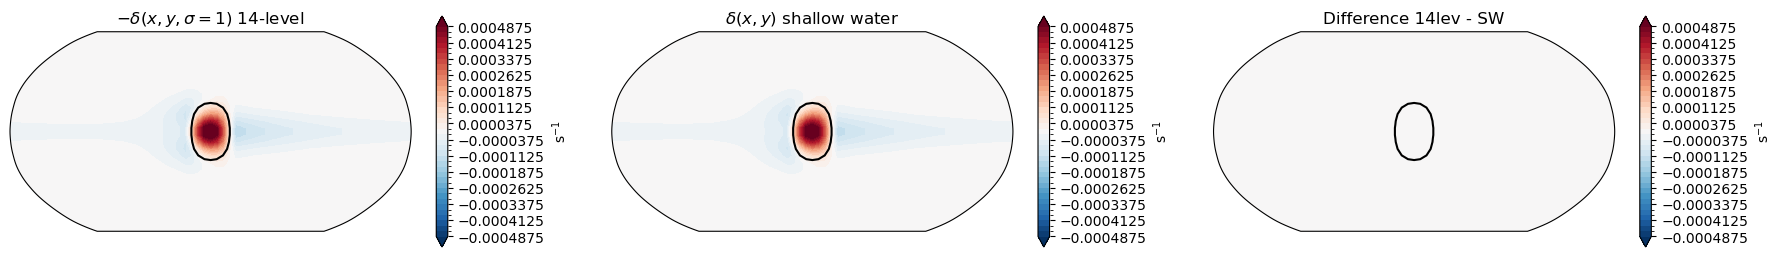

In [97]:
# Perturbation div in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
div_Nlev = (-ideal_T32.div_mean).sel(sigma=1,method='nearest')
div_SW = gill_SW_T32_mean.div
levs = np.linspace(-1.95,1.95,40) * 5e-4/2
div_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
div_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
(div_Nlev - div_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[1e-3],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$-\delta(x,y,\sigma=1)$ 14-level')
axs[1].set_title(r'$\delta(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()

Text(0.5, 1.0, 'Difference 14lev - SW')

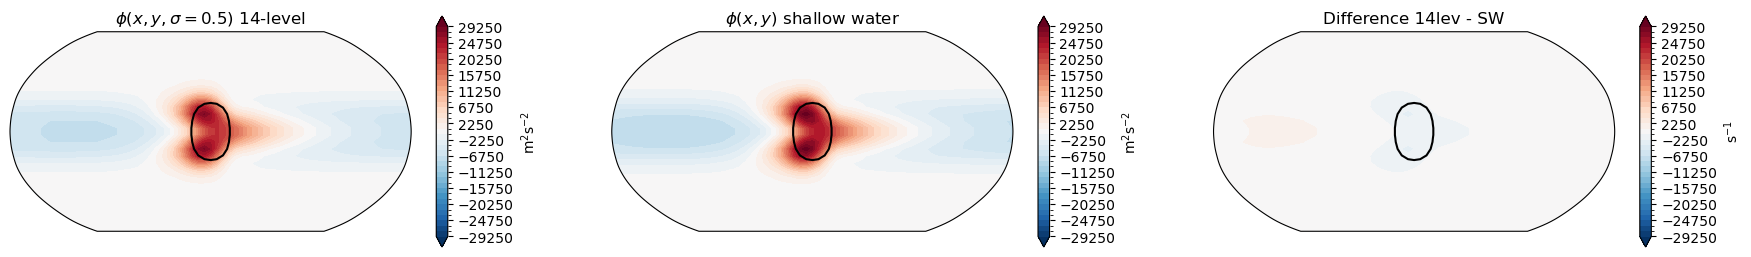

In [105]:
# Perturbation phi in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
Phi_Nlev = (ideal_T32.Phiprime_mean).sel(sigma_stag=0.5,method='nearest')
Phi_SW = gill_SW_T32_mean.h * 9.81
levs = np.linspace(-1.95,1.95,40) * 15e3
Phi_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
Phi_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(Phi_Nlev - Phi_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[1e-3],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$\phi(x,y,\sigma=0.5)$ 14-level')
axs[1].set_title(r'$\phi(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()